# Part 1: Data Cleaning

This notebook is dedicated to cleaning the goolge local datasets from http://jmcauley.ucsd.edu/data/googlelocal/ which contains the following steps that will be explained in further detail at the relevant step.  

**Table of contents**
1. [General](#general)


2. [Datasets](#datasets)\
    1.1 [Places](#places)\
    1.2 [Reviews](#reviews)\
    1.3 [Users](#users)
    

3. [Merged dataset](#merged)


4. [Additional data and filtering](#mergeadd)


5. [Exploratory Data Analysis](#eda)

<a id='general'></a>
## 1 General Code
In this part the necessary libraries for the whole notebook will be imported. 

In [ ]:
# import necessary libraries for the notebook
import json
import pandas as pd 
import numpy as np
from langdetect import detect
import matplotlib.pyplot as plt
%matplotlib inline

<a id='datasets'></a>
## 2 Datasets
The Google Local Data contains the following three main datasets: 
1. Places
2. Reviews 
3. Users

Concretely, the data contains what you see when you search for a place in Google and find the information about the place such as address or price range and the reviews from users about it. The aim is to clean the datasets that are available in json format and to merge them together into one dataset that can be used for the project.

<a id='places'></a>
### 2.1 Places
The first dataset to clean is the data about the places. This will be done in the following steps:
- Reading the available data into lists from json
- Converting the lists into a dataframe
- Cleaning the gps into a usable format
- Cleaning the prices 
- Filtering out closed places
- Dropping data that is available in a clean format now
- Filtering to US places
- Saving the clean places in the US to a csv file

**Reading data into lists**

For reading the data, lists for the different keys were created and lines were appended to the lists based on the key of the json data. 

In [ ]:
# read data into lists based on key in the data
def format_line(line, index):
    if index == 0:
        return line[:-2] + "}"
    elif index == 3114352: # last line
        return "{" + line[:-1]
    else:
        return "{" + line[:-2] + "}"

i = 0
uids = []
gpss = []
names = []
closeds = []
adresses = []
prices = []
hours = []
with open("places.json") as file:
        for line in file:
            if i <= 3114351:
                line = format_line(line, i)
        
                line_json = json.loads(line)
                uids.append(list(line_json.keys())[0])

                try:
                    gpss.append(list(line_json.values())[0]["gps"])
                except KeyError:
                    gpss.append(None)
                try:
                    names.append(list(line_json.values())[0]["name"])
                except KeyError:
                    names.append(None)
                try:
                    closeds.append(list(line_json.values())[0]["closed"])
                except KeyError:
                    closeds.append(None)
                try:
                    adresses.append(list(line_json.values())[0]["address"])
                except KeyError:
                    adresses.append(None)
                try:
                    prices.append(list(line_json.values())[0]["price"])
                except KeyError:
                    prices.append(None)
                i+=1

**Converting data into dataframe**

The lists with the different information were then merged into one dataframe for the places containing the 
- placeID
- name of the place
- gps as a tuple of the latitude and longtitude
- address
- prices in the format of the local currency e.g. €, €€, €€€ for low, medium and high price
- closed which is a boolean whether the place is closed or not

In [ ]:
# add the lists to a places dataframe
df_places = pd.DataFrame({"placeID": uids, "name":names, "gps": gpss, "adress":adresses, "price":prices, "closed":closeds})

**Cleaning location data**

As the gps data was a tuple, it needed to be split in lat and long for better usability and the address was formatted.

In [ ]:
# get the latitude and longtitude from the gps data and clean the adress
df_places['lat'] = df_places['gps'].str[0]
df_places['long'] = df_places['gps'].str[1]
for index, row in df_places.iterrows():
    df_places.at[index, 'address'] = ''.join(str(item) for item in row['adress'])

**Cleaning price data**

With prices in different currency, it would be very difficult to compare price ranges for different restaurants that is why the price was cleaned to a integer range from 1 to 3.

In [ ]:
# convert the currency specific price information to standardized price range 1-3
df_places['price_clean'] = df_places['price']
ratings_1 = ['$', '£', '€', '₩', 'R', '฿', '฿', '₱', '₸', '₡', '₴']
ratings_2 = ['$$', '££', '€€', '₱₱', '₩₩', 'RR', '฿฿', '₴₴', '₪₪', '₡₡', '₸₸', '₦₦', '₫₫', 'LL', 'QQ', '៛៛']
ratings_3 = ['$$$', '£££', '€€€', '₩₩₩', '₱₱₱', 'RRR', '₴₴₴', 'QQQ', '₫₫₫', '₡₡₡', '₪₪₪', '฿฿฿', 'LLL', '៛៛៛']
for index, row in df_places.iterrows():
    if row['price_clean'] in ratings_1:
        df_places.at[index, 'price_clean']=1
    elif row['price_clean'] in ratings_2:
        df_places.at[index, 'price_clean']=2
    elif row['price_clean'] in ratings_3:
        df_places.at[index, 'price_clean']=3
    else:
        df_places.at[index, 'price_clean']=np.nan

**Clean closed places**

The closed column contained a 2 which was cleaned and it was investigated was the closed means. When searching for a place on Google it shows closed when you search for it outside their opening hours. This was a possible explanation or the place was was permanently closed. We investigated a few examples and the places were permanently closed. As we started with a huge amount of data we decided to filter the closed places out as they would also be little helpful for e.g. recommendations.

In [ ]:
# remove places that are closed 
df_places = df_places[df_places.closed!=2]
df_places = df_places[df_places.closed==False]

**Drop unnecessary data**

Then, the columns that were cleaned before were dropped. 

In [ ]:
df_places = df_places.reset_index(drop=True)
df_places.drop(columns=['gps', 'adress', 'price', 'closed'], inplace=True)

**Filter places to US**

Finally, to reduce the amount of data further we decided to concentrate our project on the US as the reviews for these places will be in english and understandable for everyone.

In [ ]:
# define state abbreviations
state_abbreviations = [' AL',' AK',' AZ',' AR',' CA',' CO',' CT',' DE',' FL',' GA',' HI',' ID',' IL',' IN',' IA',' KS',' KY',' LA',' ME',\
' MD',' MA',' MI',' MN',' MS',' MO',' MT',' NE',' NV',' NH',' NJ',' NM',' NY',' NC',' ND',' OH',' OK',' OR',' PA',' RI',' SC',' SD',' TN',' TX',\
' UT',' VT',' VA',' WA',' WV',' WI',' WY']

In [ ]:
# get the country and state from the address
df_places['country'] = df_places['address'].apply(lambda x: "US" if any([state in x for state in state_abbreviations]) 
                                            else "Other")
def find_state(x):
    for state in state_abbreviations:
        if state in x:
            return state
        
df_places['state'] = df_places['address'].apply(lambda x: find_state(x))

In [ ]:
# filter to US only by contry and coordinates, this filtering only includes the states on the mainland and excludes Alaska
df_US = df_places.loc[df_places['country'] == 'US']
df_US = df_US[(df_US.long < -65) & (df_US.long >-130) & (df_US.lat <50) & (df_US.lat >25)]

**Save to csv file**

Below you can see an extract of the final places dataset for the US.

In [ ]:
df_US

,placeID,name,lat,long,address,price_clean,country,state
0,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA
1,103054478949000078829,Blue Ribbon Cleaners,38.979759,-76.547538,"ParoleAnnapolis, MD",NaN,US,MD
3,100327153115986850675,T C's Referee Sports Bar,43.529494,-96.792244,"5322 W 26th StSioux Falls, SD 57106",2,US,SD
6,103848836623683146185,Single Tree Inn,37.576427,-101.386182,"2033 W Oklahoma AveUlysses, KS 67880",NaN,US,KS
9,118222137795476771294,Old Chicago,45.535176,-122.862242,"17960 NW Evergreen PkwyBeaverton, OR 97006",2,US,OR
...,...,...,...,...,...,...,...,...
3014127,101013035674934053906,Antonio's Tacos,38.774187,-123.537431,"38820 California 1Gualala, CA 95445",NaN,US,CA
3014128,100209898941653537749,Marshfield Liquor Store,42.092382,-70.703062,"1852 Ocean StMarshfield, MA 02050",NaN,US,MA
3014129,113696227349469871528,Los Betos Mexican Food,34.780776,-111.762181,"6503 Arizona 179Village of Oak Creek, AZ 86351",NaN,US,AZ
3014131,113508941755053946494,Coronado Shopping Center,31.829933,-106.529536,"6001 N Mesa StEl Paso, TX 79912",NaN,US,TX


In [ ]:
df_US.to_csv('places_US_clean.csv')

<a id='reviews'></a>
### 2.2 Reviews
The second dataset to clean is the data about the reviews. This will be done in the following steps:
- Reading the available data into lists from json
- Converting the lists into a dataframe
- Clean the ratings
- Clean empty reviews and reviews with chinese characters
- Merging with the places
- Applying language detection to the reviews and filtering to english reviews

**Reading data into lists**

First, the data from the json will be read into lists again as with the places data. 

In [ ]:
# open and load json data
f = open('reviews.json')
data = json.load(f)

# get the usernames, ratings, place ids and userids that are given for all reviews

usernames = []
ratings = []
place_IDs = []
user_IDs = []
for id, info in data.items():
        for key in info:
            if key ==  'userName':
                usernames.append(info[key])
            elif key == 'rating':
                ratings.append(info[key])
            elif key == 'gPlusPlaceId':
                place_IDs.append(info[key])
            elif key == 'gPlusUserId':
                user_IDs.append(info[key])

In [ ]:
# get the dates, if not given add np.nan
dates = []
for id, info in data.items():
        keys =[]
        for key in info: 
            if key == 'texttime':
                keys.append(key)
                dates.append(info[key])
        if 'texttime' in keys:
            ""
        else:
            dates.append(np.nan)

In [ ]:
# get the times, if not given add np.nan
times = []
for id, info in data.items():
        keys =[]
        for key in info: 
            if key ==  'utime':
                keys.append(key)
                times.append(info[key])
        if 'utime' in keys:
            ""
        else:
            times.append(np.nan)

In [ ]:
# get the reviews, if not given add np.nan
reviews = []
for id, info in data.items():
        keys =[]
        for key in info: 
            if key == 'review' or key=='reviewText':
                keys.append(key)
                reviews.append(info[key])
        if 'review' in keys or 'reviewText' in keys:
            ""
        else:
            reviews.append('[]')

**Converting data to dataframe**

Then the data will also be converted into a dataframe.

In [ ]:
# convert to dictionary again and then to dataframe
dict_clean = {'username': usernames,  'userID': user_IDs,  'placeID': place_IDs, 'rating': ratings, 'review': reviews, 
              'date':dates, 'time':times, 'category': categories}
df_reviews = pd.DataFrame(dict_clean)

**Clean the ratings**

The ratings contained the values 1000, 2000, 3000, 4000, 5000 instead of 1,2,3,4,5 which was corrected in the code below and the few 0 ratings were filtered out as only 1-5 starts are valid ratings.

In [ ]:
# replace the ratings to be 1-5, drop the few 0 ratings that are in the data
df_reviews["rating"].replace({1000: 1, 2000: 2, 3000: 3, 4000: 4, 5000: 5}, inplace=True)
df_reviews = df_reviews[df_reviews.rating != 0]

C:\Users\lisa\AppData\Local\Temp\ipykernel_12600\4115036078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews["rating"].replace({1000: 1, 2000: 2, 3000: 3, 4000: 4, 5000: 5}, inplace=True)


**Clean empty reviews and reviews with chinese characters**

After that, we reduced the data further by filtering out empty reviews and reviews with chinese characters as they are unreadable for us and also the language detection that we were planning to apply on the reviews does not work with these characters. We could have also kept in the data with the empty reviews for example for the ratings, but we really aimed to reduce the data and have it as cleaned and complete as possible for the following analysis.

In [ ]:
# if review is empty ([]) than set value to np.nan and drop nan values in the dataset
df_reviews.review = df_reviews.review.apply(lambda y: np.nan if len(y)==0 else y)
df_reviews.dropna(inplace=True)

In [ ]:
# drop chinese characters with regex for them
filter = df_reviews['review'].str.contains(r'[^\x00-\x7F]+')
df_reviews = df_reviews[~filter]

**Filter to reviews of places in the US**

Filter the reviews to the US by merging them with the US places dataset.

In [ ]:
df_places_reviews = pd.merge(df_places, df_reviews, on='placeID', how='left')

**Detect language of the reviews and filter to english reviews**

Using the langdetect package, the language of the reviews was detected and the reviews were filtered to english as a preparation for the language processing and text analysis. 

<span style="color:red"> **DO NOT RUN THE CELL UNLESS YOU WANT TO HAVE IT RUNNING FOR ABOUT 12 HOURS.**</span>

In [ ]:
# function to try to detect the language if it does not work set language to unknown
def detect_my(text):
    try:
        return detect(text)
    except:
        return 'unknown'
# detect the language 
# this works but takes probably about 24 hours, so do not run again!
df_places_reviews['lang'] = df_places_reviews['review'].apply(detect_my)

In [ ]:
# filter to english reviews
df_places_reviews_en = df_places_reviews[df_places_reviews.lang == 'en']

df_places_reviews_en = df_places_reviews_en.reset_index(drop=True)

**Save to csv file**

Below you can see an extract of the final places and reviews dataset.

In [ ]:
df_places_reviews_en

,placeID,name,lat,long,address,price_clean,country,state,username,userID,rating,review,date,time
0,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Ahui 阿辉 (钓鱼者说),107847690980045434962,5.0,Wonderful place for fishing blue gills.,"Feb 19, 2014",1.392838e+09
1,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,2.0,Went fishing on 4th of July. Fishing action wa...,"Jul 4, 2013",1.372999e+09
2,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Wendy Gutierrez,113860675479510484679,4.0,great place to take the family,"Oct 13, 2013",1.381701e+09
3,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Gayle O&#39;Malley-Ybarra,117297746111101622650,5.0,Very romantic,"May 30, 2013",1.369951e+09
4,103054478949000078829,Blue Ribbon Cleaners,38.979759,-76.547538,"ParoleAnnapolis, MD",NaN,US,MD,Lavette Schweisgut,112738432136607174994,5.0,I have referred both clients and colleagues to...,"Apr 30, 2013",1.367357e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853567,100753085206968749306,Assembly of God Church High School,21.044020,75.802731,"Near Sambhaji Nagar, Varangaon Rd, Gandhi Naga...",NaN,Other,None,rakesh ranade,112721958077982795221,5.0,Rakesh Ranade Asst Teacher,"Feb 17, 2014",1.392655e+09
6853568,110683973849480222025,Buccaneer,34.161776,-118.054231,"70 W Sierra Madre BlvdSierra Madre, CA 91024",NaN,US,CA,Carroll Brown,101337749570073056985,4.0,It's a friendly neighborhood bar where one can...,"Dec 8, 2012",1.355028e+09
6853569,110683973849480222025,Buccaneer,34.161776,-118.054231,"70 W Sierra Madre BlvdSierra Madre, CA 91024",NaN,US,CA,Lorraine Calderon,108277088975589526167,5.0,Love to see Dave Shelton play here! Great inti...,"Aug 8, 2013",1.376018e+09
6853570,110683973849480222025,Buccaneer,34.161776,-118.054231,"70 W Sierra Madre BlvdSierra Madre, CA 91024",NaN,US,CA,hank eileen doupe,110117352603000727391,5.0,Everyone knows you,"Sep 2, 2012",1.346652e+09


In [ ]:
# safe to csv dataset
df_places_reviews_en.to_csv('places_US_en_reviews_clean.csv')

<a id='users'></a>
### 2.3 Users
The second dataset to clean is the data about the users. This will be done in the following steps:
- Reading data into lists
- Converting data to dataframe
- Save to csv file

**Reading data into lists**

First, the data from the json will be read into lists again as with the places and reviews data. 

In [ ]:
# Open JSON file
f = open('users.json')
 
# returns JSON object as a dictionary
data = json.load(f)

In [ ]:
# get keys from the data
keys = data.keys()
usernames = []
currentplace = []
education = []
jobs = []
prevplaces = []

# get lists of the data based on the key
for key in keys:
    try:
        usernames.append(data[key]["userName"])
    except KeyError:
        usernames.append(None)
    try:
        currentplace.append(data[key]['currentPlace'])
    except KeyError:
        currentplace.append(None)
    try:
        education.append(data[key]['education'])
    except KeyError:
        education.append(None)
    try:
        jobs.append(data[key]['jobs'])
    except KeyError:
        jobs.append(None)
    try:
        prevplaces.append(data[key]['previousPlaces'])
    except KeyError:
        prevplaces.append(None)

**Converting data to dataframe**

Then the data will also be converted into a dataframe.

In [ ]:
# save user info to dataframe
df_user = pd.DataFrame()

df_user["userID"] = keys
df_user["userName"] = usernames
df_user['currentPlace'] = currentplace
df_user["education"] = education
df_user["jobs"] = jobs
df_user['previousPlaces'] = prevplaces

**Save to csv file**

Below you can see an extract of the final user dataset for the US.

In [ ]:
df_user

,userID,userName,currentPlace,education,jobs,previousPlaces
0,100000010817154263736,an lam,"[Thành phố Hồ Chí Minh, Việt Nam, [[], 1082309...","[[[], [], [], [], [], 6], [[Đại học Kiến trúc ...","[[Tổng công ty IDICO, Chuyên viên Kỹ thuật XD,...","[[tp. Nam Định, Nam Định, Việt Nam, [[], 20420..."
1,100000013500285534661,HALİL TURGUT,"[Adana, [[], 370000000, 353213330, 1]]","[[[], [], [], [], [], 6], [[Anadolu University...","[[Mustafa Nevzat İlaç San. A.Ş., Rebrezant, []...",[]
2,100000021336848867366,森田さとこ,[],"[[[], [], [], [], [], 6], []]",[],[]
3,100000030557048145331,amey kore,[],"[[[], [], [], [], [], 6], []]",[],[]
4,100000032416892623125,william spindler,[],"[[[], [], [], [], [], 6], []]",[],[]
...,...,...,...,...,...,...
3747932,114675878141148336835,Andrei Mustea,[],"[[[], [], [], [], [], 6], []]",[],[]
3747933,114675879178455853299,ahmed alalam,[],"[[[], [], [], [], [], 6], []]",[],[]
3747934,114675884186004222559,Brad Shaffer,[],"[[[], [], [], [], [], 6], []]",[],[]
3747935,114675887865682990096,Ashley Krueger,[],"[[[], [], [], [], [], 6], []]",[],[]


In [ ]:
df_user.to_csv('Users_clean.csv')

<a id='merged'></a>
## 3 Merged dataset
Finally the user data will be merged to the rest to create the complete dataset with places, reviews and users.

In [ ]:
# merge the user data to the rest
df = pd.merge(df_places_reviews_en, df_user, on="userID", how="left")

In [ ]:
# drop the userName column and keep username
df.drop(columns=['userName'], inplace=True)

In [ ]:
# save to csv
df.to_csv('Clean_dataset_with_places_reviews_users_US.csv')

<a id='mergeadd'></a>
## 4 Merge additional data and additional filtering
As data analytics is an iterative process and we discovered more about the data there was additional operations necessary and we did not want to run the language detection again, so we worked with the established dataset to make alterations.

We identified the following needs 
- Adding the categories of the places to see what kind of places people like or are interested in
- Filtering the data to the US as we merged the reviews with the places and not only the US places
- Only include users with 3 or more reviews as there is little to conclude about a user with only one review and place

**Adding and cleaning the categories**

The first need was to add the categories of the places to the data. Therefore, the reviews were read in again with the placeID and merged to the dataset. Also the first category of the list of categories for a place was extracted as this is the most informative about the place and present for most places.

In [ ]:
# read the cleaned dataset in again
import pandas as pd
df = pd.read_csv('Clean_dataset_with_places_reviews_users_US.csv')

In [ ]:
# open the reviews again and get the categories out
import json
f = open('reviews_clean.json')
data = json.load(f)
import numpy as np
categories = []
place_IDs = []

for id, info in data.items():
        keys =[]
        for key in info: 
            if key == 'categories':
                keys.append(key)
                categories.append(info[key])
            elif key == 'gPlusPlaceId':
                place_IDs.append(info[key])
        if 'categories' in keys:
            ""
        else:
            categories.append(np.nan)

In [ ]:
# save to dataframe
dict_cat = {'placeID':place_IDs, 'category': categories}
df_cat = pd.DataFrame(dict_cat)

# extract the first category and drop duplicates as we only need it once for each placeID
df_cat['category1'] = df_cat['category'].str[0]
df_cat.drop_duplicates('placeID', keep='first', inplace=True)
placeIDs = df.placeID.unique().tolist()
boolean_series = df_cat.placeID.isin(placeIDs)
df_cat_filt = df_cat[boolean_series]

# merge together with the dataset
df_all = pd.merge(df, df_cat_filt, on='placeID', how='left')

# filter the data further down to the places that contain at least one category
df_all = df_all[df_all['category1'].notna()]

**Filtering to the US**

The second need was established int he exploratory data analysis where we saw that the reviews were merged with the whole places dataset instead of the US only, so we went back to the cleaning and restricted to the US afterwards. There was also one specific point that we spotted on the map in Mexico when scatter plotting the latitudes and longtitudes that we filtered out explicitly.

In [ ]:
# filter to country us, additional filtering to the latitude and longtitude and the one place in Mexico that was identfied visually
df_all = df_all[df_all.country=='US']
df_all = df_all[(df_all.long < -65) & (df_all.long >-130) & (df_all.lat <50) & (df_all.lat >25)]
df_all = df_all[df_all.placeID!='100088348763121427563']

**Filtering to users with more than three reviews**

To make more meaningful user profiles and reduce our data furhter, we also decided to concentrate on the users with 3 or more reviews.

In [ ]:
# count the number of reviews for each user and filter the dataset to reviews and users with at least 3 reviews
US_counts = df_all.groupby('userID').size().reset_index(name = 'count')
US_counts = US_counts[US_counts['count'] >=3]
df_all_3_reviews_user = pd.merge(df_all, US_counts, on = 'userID')

**Save the dataset**

Below you can see an extract of the dataset before it is saved to a csv file.

In [ ]:
# drop the old index column from the dataset
df_all_3_reviews_user.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
# overview of the final cleaned dataset
df_all_3_reviews_user

,placeID,name,lat,long,address,price_clean,country,state,username,userID,...,date,time,lang,currentPlace,education,jobs,previousPlaces,category,category1,count
0,104699454385822125632,Diamond Valley Lake Marina,33.703804,-117.003209,"2615 Angler AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,"Jul 4, 2013",1.372999e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],"[Marina, Recreation, Fishing Lake]",Marina,19
1,117477090906709658119,Pins & Needles Pro Shop,33.747513,-116.998209,"2850 W Florida AveHemet, CA 92545",NaN,US,CA,Keith Willems,109283356541834506464,...,"Jul 12, 2013",1.373637e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],[Bowling Supply Shop],Bowling Supply Shop,19
2,118090863044520175763,Naval Base Ventura County: Point Mugu,34.118670,-119.119901,"311 Main Rd #1Point Mugu, CA 93042",NaN,US,CA,Keith Willems,109283356541834506464,...,"Jun 25, 2013",1.372175e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],[Naval Base],Naval Base,19
3,105634554085759078039,Gastrognome,33.744194,-116.713366,"54381 Ridge View DrIdyllwild-Pine Cove, CA 92549",2.0,US,CA,Keith Willems,109283356541834506464,...,"Sep 3, 2013",1.378270e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],[American Restaurant],American Restaurant,19
4,103361583221732042437,Apollo Burgers,33.840312,-118.236400,"21239 S Wilmington AveCarson, CA 90810",NaN,US,CA,Keith Willems,109283356541834506464,...,"Jul 3, 2013",1.372875e+09,en,"['Valle Vista, CA, United States', [[], 337477...","[[[], [], [], [], [], 6], [['Southern Californ...","[['mt plaza mail and ship', 'shipper', [[1, 1,...",[],"[Fast Food Restaurant, American Restaurant, Ha...",Fast Food Restaurant,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610136,117401946410421774884,Jethro's BBQ,41.603722,-93.660008,"3100 Forest AveDes Moines, IA 50311",2.0,US,IA,Whitney Lemon,114643192462777583189,...,"Jan 28, 2013",1.359398e+09,en,[],"[[[], [], [], [], [], 6], []]","[['Google', 'Marketing Associate', [[1, 1, 201...",[],"[Barbecue Restaurant, Takeout Restaurant, Fami...",Barbecue Restaurant,3
1610137,117457942094697101318,Fong's Pizza,41.585927,-93.621827,"223 4th StDes Moines, IA 50309",3.0,US,IA,Whitney Lemon,114643192462777583189,...,"Oct 30, 2012",1.351636e+09,en,[],"[[[], [], [], [], [], 6], []]","[['Google', 'Marketing Associate', [[1, 1, 201...",[],"[Pizza Restaurant, European Restaurant, Bar]",Pizza Restaurant,3
1610138,111334454331136130451,The Mucky Duck,26.522452,-82.193009,"11546 Andy Rosse LnCaptiva, FL 33924",2.0,US,FL,Dave Johnson,100023203599080783253,...,"Feb 25, 2014",1.393388e+09,en,[],"[[[], [], [], [], [], 6], []]",[],[],"[Restaurant, American Restaurant]",Restaurant,3
1610139,114736260740047855654,Boston Market,36.089022,-79.886255,"5615 W Friendly AveGreensboro, NC 27410",3.0,US,NC,Dave Johnson,100023203599080783253,...,"May 10, 2013",1.368205e+09,en,[],"[[[], [], [], [], [], 6], []]",[],[],"[Chicken Restaurant, American Restaurant, Fast...",Chicken Restaurant,3


In [ ]:
# save the final dataset that will be used for the project further
df_all_3_reviews_user.to_csv('Clean_dataset_google_local_data_with_3+_reviews.csv', index=False)

<a id='eda'></a>
## 5 Exploratory Data Analysis 
The cleaned dataset has the following basic information
- 1610141 reviews (rows)
- 22 columns with data about the reviews
- 747640 places that were reviewed in the US
- 246204 users that reviewed these places and at least 3 of them
- reviews for a timespan from 1990 - 2014

In [ ]:
# import the dataset as that was done after the cleaning process 
import pandas as pd
df = pd.read_csv('Clean_dataset_google_local_data_with_3+_reviews.csv')

In [ ]:
# get the shape
df.shape

(1610141, 22)

In [ ]:
# get the overall number of users
df.userID.nunique()

246204

In [ ]:
# get the overall number of places
df.placeID.nunique()

747640

**Locations**

Explore the final locations in the dataset by plotting the latitudes and longitudes. 

In [ ]:
# reduce dataset to unique places with locations only to plot less data
df_loc = df[['placeID' , 'name', 'lat', 'long', 'state', 'category1', 'category_high_level', 'price_clean', 'count']]
df_loc.drop_duplicates(inplace=True)

C:\Users\lisa\AppData\Local\Temp\ipykernel_13192\893348888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc.drop_duplicates(inplace=True)


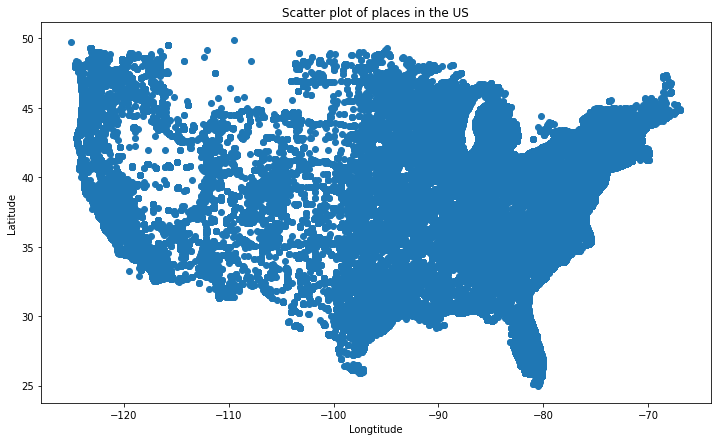

In [ ]:
# scatter plot the lats and lons of the places
mport matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.scatter(df_loc['long'], df_loc['lat'])
plt.title('Scatter plot of places in the US')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.show()

**Findings**

What is quite interesting to see is that the east coast is covered with reviews locations and you can clearly see lake Michigan (the white boomerang shpaed area at the north east of the map surrounded by places from the dataset). Also, the west coast is more sparse in terms of reviews especially in the area of the Rocky Mountains which makes sense.

**Distributions**

Also, a clearer look at the distribution of the numeric and categoric data will be taken.

In [ ]:
def find_category(x):
    if 'Restaurant' in x or 'Steak House' in x:
        return 'Restaurant'
    elif 'Sandwich Shop' in x or 'Coffee Shop' in x:
        return 'Takeaway'
    elif 'Supermarket' in x or 'Grocer' in x:
        return 'Groceries'
    elif 'Bar' in x or 'Pub' in x:
        return 'Bar'
    elif 'Shopping' in x:
        return 'Shopping'
    elif 'Service' in x or 'Plumber' in x:
        return 'Services'
    elif 'Hotel' in x or 'Motel' in x or 'Resort' in x:
        return 'Overnight Stay'
    elif 'Tire' in x or 'Car' in x or 'Auto' in x or 'Toyota' in x or 'Ford' in x or 'Transmission' in x:
        return 'Automotive'
    elif 'Park' in x:
        return 'Park'
    elif 'Physician' in x or 'Dentist' in x or 'Doctor' in x or 'Pharma' in x or 'Health' in x:
        return 'Health'
    elif 'Skin' in x or 'Salon' in x or 'Hair' in x:
        return 'Personal Grooming'
    elif 'Veterinarian' in x:
        return 'Veterinarian'
    elif 'Movie' in x or 'Theater' in x or 'Cinema' in x or 'Comedy' in x:
        return 'Entertainment'
    elif 'Night Club' in x or 'Strip Club' in x or 'Adult Entertainment' in x or 'Sex' in x:
        return 'Adult Entertainment'
    elif 'Real Estate' in x or 'Property' in x:
        return 'Real Estate'
    elif 'Tattoo' in x:
        return 'Tattoo'
    elif 'Self-Storage' in x:
        return 'Self-Storage'
    elif 'University' in x or 'School' in x:
        return 'Education'
    elif 'Lesbian' in x:
        return 'Lesbian/Gay Organization'
    else:
        return 'Other'

In [ ]:
df['category_high_level'] = df['category1'].apply(lambda x: find_category(x))

In [ ]:
df['year'] = df.date.str.split(',').str[1]

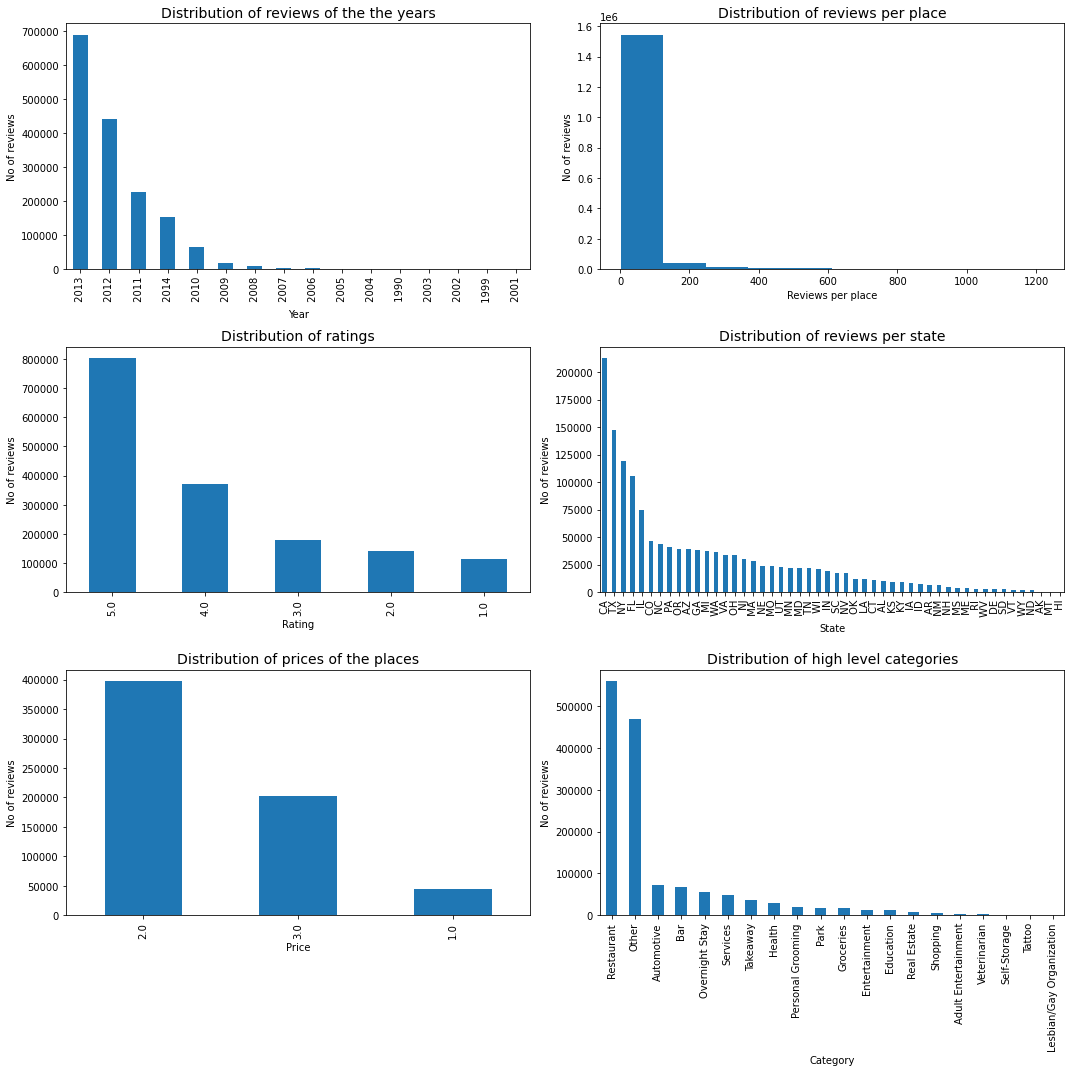

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
df.year.value_counts().plot(kind='bar')
plt.title('Distribution of reviews of the the years', fontsize=14)
plt.xlabel('Year')
plt.ylabel('No of reviews')

plt.subplot(3,2,2)
plt.hist(df['count'])
plt.title('Distribution of reviews per place', fontsize=14)
plt.xlabel('Reviews per place')
plt.ylabel('No of reviews')

plt.subplot(3,2,3)
df.rating.value_counts().plot(kind='bar')
plt.title('Distribution of ratings', fontsize=14)
plt.xlabel('Rating')
plt.ylabel('No of reviews')

plt.subplot(3,2,4)
df_loc.state.value_counts().plot(kind='bar')
plt.title('Distribution of reviews per state', fontsize=14)
plt.xlabel('State')
plt.ylabel('No of reviews')

plt.subplot(3,2,5)
df_loc.price_clean.value_counts().plot(kind='bar')
plt.title('Distribution of prices of the places', fontsize=14)
plt.xlabel('Price')
plt.ylabel('No of reviews')


plt.subplot(3,2,6)
df_loc.category_high_level.value_counts().plot(kind='bar')
plt.title('Distribution of high level categories', fontsize=14)
plt.xlabel('Category')
plt.ylabel('No of reviews')
plt.tight_layout()

**Findings**

Interesting findings from this analysis were for us especially 
- The distribution of ratings with mostly 5.0 star ratings, we expected a lot of 5.0 and 1.0 ratings as we imagined that people mostly write reviews when they are extremely satisfied or disappointed with a place
- That 2013 had far the most reviews, we expected a more even distribution over the years especially after 2000
- The fact that there were mainly top 5 states with high numbers of reviews (California, Texas, New York, Illinois and Florida) and that Texas is the state with the second most reviews after California as we expected New York.